In [15]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.special import kv
from scipy import interpolate
from scipy.special import kv as scipy_bessel_func
from scipy.special import gamma as scipy_gamma_func
%matplotlib inline

In [2]:
preproc_files_dir = '/cluster/tufts/hugheslab/prath01/projects/MASTRE/datasets'
static_df = pd.read_csv(os.path.join(preproc_files_dir, 'static_features.csv'))
highfreq_df = pd.read_csv(os.path.join(preproc_files_dir, 'highfreq_features.csv'))
target_outcomes_df = pd.read_csv(os.path.join(preproc_files_dir, 'target_level_marksmanship_outcomes.csv'))
highfreq_df.sort_values(by=['subject_uid', 'mission_phase', 'target_id', 'shot_id'], inplace=True)

In [3]:
def get_fenceposts(df, id_cols):
    keys_df = df[id_cols].copy()
    for col in id_cols:
        if not pd.api.types.is_numeric_dtype(keys_df[col].dtype):
            keys_df[col] = keys_df[col].astype('category')
            keys_df[col] = keys_df[col].cat.codes
    fp = np.hstack([0, 1 + np.flatnonzero(np.diff(keys_df.values, axis=0).any(axis=1)), keys_df.shape[0]])
    return fp


## Create a dictionary of various covariates

In [4]:
# Get the aim trace data in post 3 last target
targets_list = ['4 sessions_POST3', '3 sessions_POST3', '2+3 sessions_POST3', '1+2+3 sessions_POST3']
covariates_dict = dict.fromkeys(targets_list)
time_col = 'seconds_from_session_start'
id_cols = ['subject_uid', 'mission_phase', 'target_id', 'shot_id']
feature_cols = ['shot_x_aim_trace', 'shot_y_aim_trace', 'shot_d_aim_trace']
predict_mission_phase = 'POST3'
predict_target_id = '4'


# perform linear regression to predict performance on last target adding aim trace 
# covariates from prev. sessions in every loop
for i, targets in enumerate(targets_list):
    targets_sessions = targets.split(' ')
    sessions = targets_sessions[1].split('_')[1]
    target_ids = targets_sessions[0].split('+')
    
    if sessions == 'all':
        x_df = reduced_df[(reduced_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
#         y_df = target_outcomes_df[(target_outcomes_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
        
    else:
        x_df = highfreq_df[(highfreq_df.mission_phase==sessions)&
                           (highfreq_df.target_id.isin(target_ids))].copy().reset_index(drop=True)
    y_df = target_outcomes_df[(target_outcomes_df.mission_phase==predict_mission_phase)&
                                  (target_outcomes_df.target_id == predict_target_id)].copy().reset_index(drop=True)
    
    x_df.sort_values(by=id_cols, inplace=True)
    x_df_ids = x_df.drop_duplicates(subset=['subject_uid'])[['subject_uid']]
    y_df = pd.merge(y_df, x_df_ids, on=['subject_uid'], how='inner')
    x_df = x_df[x_df.subject_uid.isin(y_df.subject_uid)]
        
    covariates_dict[targets] = dict()
    covariates_dict[targets]['x'] = x_df
    covariates_dict[targets]['y'] = y_df


## Get the shot trace of all shots started to time zero

In [5]:
x_df = covariates_dict['4 sessions_POST3']['x']

In [74]:
fp_key_cols = ['subject_uid', 'mission_phase', 'target_id']
fps = get_fenceposts(x_df, fp_key_cols)
fs = 66.6

reduced_df_list = list()
nrows = len(fps)-1
t_list = list()
x_list = list()

# t_new = np.arange(0,10,1/fs)
for p in range(nrows):
    fp_start = fps[p]
    fp_end = fps[p+1]
    x = x_df.iloc[fp_start:fp_end, :]['shot_d_aim_trace'].values
    t = np.arange(0, len(x))/fs
#     if x.shape[0]>10:
#         f = interpolate.interp1d(t, x, fill_value='extrapolate')
#         x_new = f(t_new)
    x_list.append(x)
    t_list.append(t)


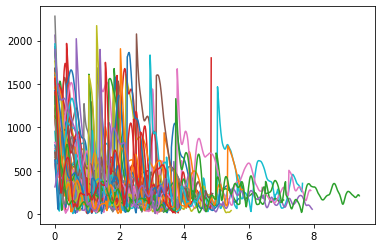

In [75]:
f, axs = plt.subplots(1,1)

for i in range(len(x_list)):
    axs.plot(t_list[i], x_list[i])

plt.show()

## Define GP  functions

In [98]:
def matern_kernel_func(x_grid_A, x_grid_B=None, **kernel_kwargs):
    if x_grid_B is None:
        x_grid_B = x_grid_A.copy()
    A = x_grid_A.shape[0]
    B = x_grid_B.shape[0]
    xa_A1 = np.reshape(x_grid_A, (A, 1))
    xb_1B = np.reshape(x_grid_B, (1, B))
    
    nu = kernel_kwargs['nu']
    L = kernel_kwargs['L']

    r_AB = np.abs(xa_A1 - xb_1B)
    r_AB[r_AB==0] = np.finfo(float).eps
    z_AB = np.sqrt(2*nu) / L * r_AB
    return (
        2.0**(1.0-nu) / scipy_gamma_func(nu)
        * z_AB**nu
        * scipy_bessel_func(nu, z_AB)
    )

def sqexp_kernel_func(x_grid_A, x_grid_B=None, **kernel_kwargs):
    if x_grid_B is None:
        x_grid_B = x_grid_A.copy()
    A = x_grid_A.shape[0]
    B = x_grid_B.shape[0]
    xa_A1 = np.reshape(x_grid_A, (A, 1))
    xb_1B = np.reshape(x_grid_B, (1, B))
    
    L = kernel_kwargs['L']
    return np.exp(-0.5/L**2 * np.square(xa_A1 - xb_1B))

def mean_func(x_grid_G):
    return np.zeros_like(x_grid_G)

def draw_GP_prior_sample_at_x_grid(
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP prior given mean/cov functions

    Args
    ----
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value 
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    random_seed : int
        See for the random number generator
    n_samples : int
        Number of samples to draw from the prior    

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    prng = np.random.RandomState(int(random_seed))
    mean_G = mean_func(x_grid_G)
    cov_GG = cov_func(x_grid_G, **kernel_kwargs)
    
    f_SG = prng.multivariate_normal(mean_G, cov_GG, size=n_samples)
    return f_SG

def draw_GP_posterior_samples_at_x_grid(
        x_train_N, y_train_N,
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        sigma=0.1,
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP posterior given data and mean/cov functions

    Args
    ----
    x_train_N : 1D array, size n_train_pts (N)
    y_train_N : 1D array, size n_train_pts (N)
    x_grid_G : 1D array, size n_grid_pts (G)
    
    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    prng = np.random.RandomState(int(random_seed))
    mean_G, cov_GG = calc_posterior_params__mean_G_and_cov_GG(
        x_train_N, y_train_N, x_grid_G, mean_func, cov_func, sigma, **kernel_kwargs)
    f_SG = prng.multivariate_normal(mean_G, cov_GG, size=n_samples)
    return f_SG

def calc_posterior_params__mean_G_and_cov_GG(
        x_train_N,
        y_train_N,
        x_test_G,
        mean_func=None,
        cov_func=None,
        sigma=0.1,
        **kernel_kwargs):
    """ Compute parameters of posterior Gaussian for each test point
    
    Returns
    -------
    mean_G : 1D array, size G
        Posterior mean vector
    cov_GG : 2D array, size G x G
        Posterior covariance matrix
    
    References
    ----------
    Alg. 2.1 of GPML book by Rasmussen and Williams
    http://www.gaussianprocess.org/gpml/chapters/RW2.pdf#page=13
    """
    N = x_train_N.shape[0]
    G = x_test_G.shape[0]
    K_NN = cov_func(x_train_N, **kernel_kwargs)
    K_GN = cov_func(x_test_G, x_train_N, **kernel_kwargs)
    K_GG = cov_func(x_test_G, **kernel_kwargs)
    
    L_NN = np.linalg.cholesky(K_NN + np.square(sigma) * np.eye(N))
    alpha_N = np.linalg.solve(L_NN.T, np.linalg.solve(L_NN, y_train_N))
    mean_G = np.matmul(K_GN, alpha_N)
    tmp_NG = np.linalg.solve(L_NN, K_GN.T)
    cov_GG = K_GG - np.matmul(tmp_NG.T, tmp_NG)
    return mean_G, cov_GG

def plot_f_samples_at_x_grid(x_grid_G, f_grid_SG,
                             color=None, label=None, ymin=-5, ymax=+5, axis_handle=None):
    if axis_handle is None:
        axis_handle = pylab.gca()
    S, G = f_grid_SG.shape
    for s in range(S):
        if s==0:
            axis_handle.plot(x_grid_G, f_grid_SG[s], color=color, label=label)
        else:
            axis_handle.plot(x_grid_G, f_grid_SG[s], color=color)
    if ymin is not None:
        axis_handle.set_ylim([ymin, ymax])

## Drawing from GP Prior

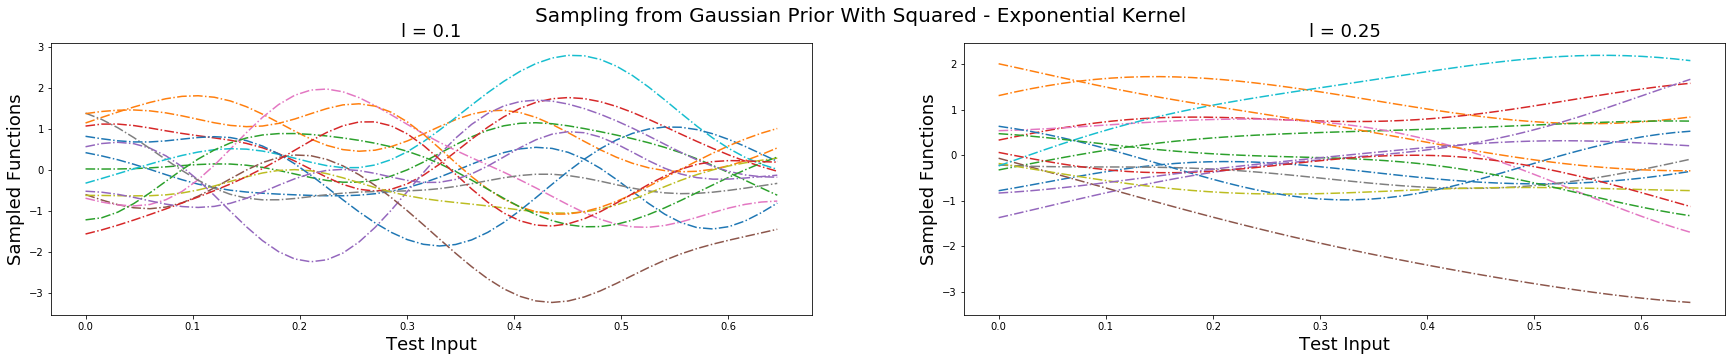

In [20]:
G = 200
x_grid_G = np.asarray(t_list[0])
l = [0.1, 0.25]
n_samples = 15

# draw from prior for different l values
f_SG_list = []
for l_val in l: 

#     f_SG = draw_GP_prior_samples_at_x_grid(x_grid_G, np.zeros_like, sqexp_kernel_func(x_grid_G,x_grid_G,l_val), 42, n_samples)
    f_SG = draw_GP_prior_sample_at_x_grid(
        x_grid_G, mean_func, sqexp_kernel_func,
        kernel_kwargs=dict(L=l_val), n_samples=n_samples)
    f_SG_list.append(f_SG)

# # plot 1 x 3 columns of 5 samples drawn from the GP prior at various values of l    
fontsize = 18
f, axs = plt.subplots(1,len(l))
for l_ind, l_val in enumerate(l):
    axs[l_ind].plot(x_grid_G,np.asarray(f_SG_list[l_ind].T), '-.')
    axs[l_ind].set_title('l = ' + str(l_val), fontsize= fontsize)
    axs[l_ind].set_xlabel('Test Input', fontsize = fontsize)
    axs[l_ind].set_ylabel('Sampled Functions', fontsize=fontsize)

f.set_figheight(5)
f.set_figwidth(30)
f.suptitle('Sampling from Gaussian Prior With Squared - Exponential Kernel', fontsize= 20)
plt.show()

## Drawing from GP Posterior

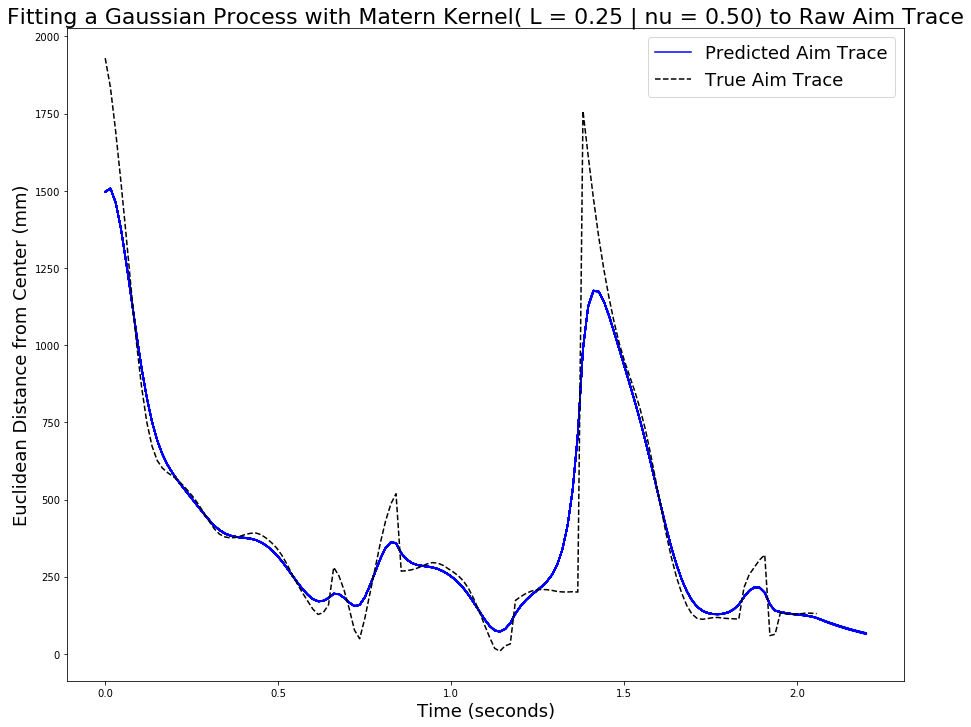

In [110]:
x_train_N = np.asarray(t_list[0])
y_train_N = np.asarray(x_list[0])
sigma = .8
n_samples = 50
# x_grid = np.asarray(t_list[0])

ell_list = [0.25]
nu_list = [0.5]

x_grid = np.linspace(0, 2.2, 1000)

fig_h, axes_grid_RC = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=True,
    figsize=(15,12))
for cc, L in enumerate(ell_list):
    for rr, nu in enumerate(nu_list):
        f_grid_SG = draw_GP_posterior_samples_at_x_grid(
            x_train_N, y_train_N,
            x_grid, mean_func, matern_kernel_func,
            kernel_kwargs=dict(L=L, nu=nu),
            sigma=sigma,
            n_samples=n_samples)
        plot_f_samples_at_x_grid(
            x_grid,
            f_grid_SG,
            color='b',
            axis_handle=axes_grid_RC,
            label='Predicted Aim Trace',
            ymin=None
            )
        axes_grid_RC.plot(t_list[0], x_list[0], 'k--', markersize=12, label = 'True Aim Trace')
        axes_grid_RC.set_title('Fitting a Gaussian Process with Matern Kernel( L = %.2f | nu = %.2f) to Raw Aim Trace' 
                               % (L,nu), fontsize=fontsize+4)
        axes_grid_RC.set_ylabel('Euclidean Distance from Center (mm)', fontsize=fontsize)
        axes_grid_RC.set_xlabel('Time (seconds)', fontsize=fontsize)

plt.legend(fontsize=fontsize)
plt.show()

fig_h.savefig('Aim_trace_GP.png', dpi=300)



In [88]:
f_grid_SG.shape

(50, 1000)

In [84]:
y_train_N

array([1929.65801115, 1835.48394981, 1694.46903778, 1534.00305736,
       1361.13702837, 1181.59221815, 1010.96168572,  865.44158093,
        751.4280072 ,  674.00667652,  627.07301808,  602.24078241,
        587.39664623,  575.72337976,  562.39887091,  545.85731652,
        527.45814052,  507.03729646,  483.25523277,  456.88510591,
        430.08224795,  405.38328777,  388.08258142,  379.29588714,
        376.11500901,  376.91406182,  381.47075904,  387.04327923,
        390.77870976,  391.86487467,  386.38526111,  375.0854436 ,
        360.80271618,  343.3485838 ,  320.16986117,  290.5564489 ,
        257.85695647,  226.61478328,  197.86156777,  170.92469102,
        145.05119786,  127.85593455,  134.28782521,  159.00154087,
        280.42441049,  253.28199699,  206.71178002,  146.02373095,
         77.04050882,   49.28326288,  116.13647145,  197.23399808,
        279.93150948,  360.91224695,  431.42127903,  485.64977093,
        518.93353139,  268.29396191,  269.64764045,  272.64618

In [221]:
a = np.asarray(t_list)
b = np.asarray(t_list[0]).reshape(1,-1)
try:
    a.shape[1]
except IndexError as e:
    a = a.reshape(-1,1)

try:
    b.shape[1]
except IndexError as e:
    b = b.reshape(-1,1)

# # subtract every element in a from every element in b
d = a.T@np.ones_like(b) -  np.ones_like(a.T)@b

# # compute squared exponential
# k = np.exp(-.5*d**2/l**2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 232)

In [222]:
a.T@np.ones_like(b).shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 232)

In [113]:
covariates_dict[targets]['y'].describe()

,subject_uid,mobility,lethality,stability
count,45.000000,45.000000,45.000000,45.000000
mean,2114.355556,0.729340,843.046446,172735.241309
std,795.263797,0.264894,283.537724,172140.613884
min,1001.000000,0.327857,313.943646,8595.565000
25%,1401.000000,0.519375,660.159804,60850.842500
50%,2202.000000,0.667500,779.759338,112641.471429
75%,3001.000000,0.907500,1000.524605,206571.806667
max,3405.000000,1.402500,1576.347414,693835.290000
